<center>
    <h1><b>Phân Tích và Dự Đoán Trạng Thái Tâm Lý Qua Miêu Tả Dạng Văn Bản</b></h1>
    <h2><b> Tiền xử lý dữ liệu và trực quan hóa </b></h2>
    <h3><b>Học phần: Học máy</b></h3>
    <h4><b>Giảng viên: TS. Cao Văn Chung</b></h4>
</center>

---
**Sinh viên thực hiện:**
- Trần Anh Minh - 21000242
- Dương Đức Vương - 22000133
- Nguyễn Tuấn Kiệt - 22000100

Các thư viện cần thiết

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Tiền xử lý

Đọc dữ liệu

In [ ]:
df = pd.read_csv("New Data.csv")
df.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

Xóa cột số thứ tự không cần thiết

In [ ]:
df.drop('Unnamed: 0',axis=1,inplace=True)

Xem 1 vài ví dụ

In [ ]:
df.sample(3)

statement      status
42224  i reaaly miss john mayer s twitter fuck rude p...      Normal
19008  This week, I do not give any attention to anyt...  Depression
10728  There is not much to say really, my gp wanted ...  Depression

Đếm số mẫu mỗi nhãn

In [ ]:
df['status'].value_counts()

status
Depression              26057
Normal                  16351
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

Quan sát trực quan phân bố mẫu

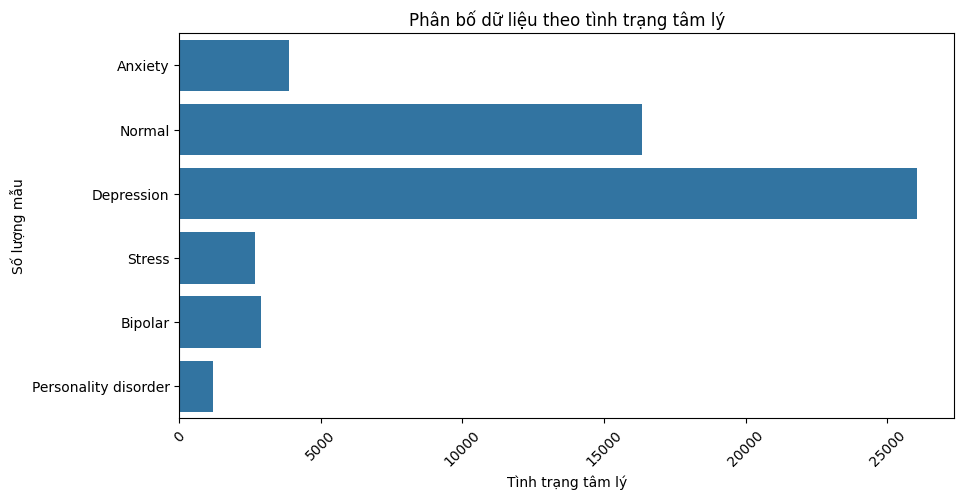

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['status'])
plt.xlabel("Tình trạng tâm lý")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố dữ liệu theo tình trạng tâm lý")
plt.xticks(rotation=45)
plt.show()

Đếm số dòng có dữ liệu trống

In [ ]:
df.isna().sum()

statement    362
status         0
dtype: int64

Loại bỏ các dòng có dữ liệu trống

In [ ]:
df.dropna(inplace=True)

Các bước tiền xử lý:

- Chuyển về viết thường
- Xóa các kí tự đặc biệt không phải chữ hoặc số
- Chuyển các động từ về nguyên thể, các từ về gốc của nó.

In [ ]:
pt = PorterStemmer()
def preprocessing(x):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', x.lower())
    return " ".join(pt.stem(word) for word in text.split())

df['statement'] = df['statement'].apply(preprocessing)

Kiểm tra thông tin hậu tiền xử lý

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


Mã hóa nhãn

In [ ]:
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status'])
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

Ta vector hóa các văn bản bằng phương pháp TF-IDF (Giới hạn số chiều là 1000 để thuận tiện tính toán dù số chiều có thể lên đến hơn 62000)

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['statement'])

# Trực quan hóa bằng PCA

Ta lấy 4 thành phần chính có tỷ lệ phương sai lớn nhất

In [ ]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_tfidf.toarray())
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['status'] = df['status']

Quan sát dữ liệu khi chiếu xuống 2 thành phần chính có độ lý giải phương sai cao nhất

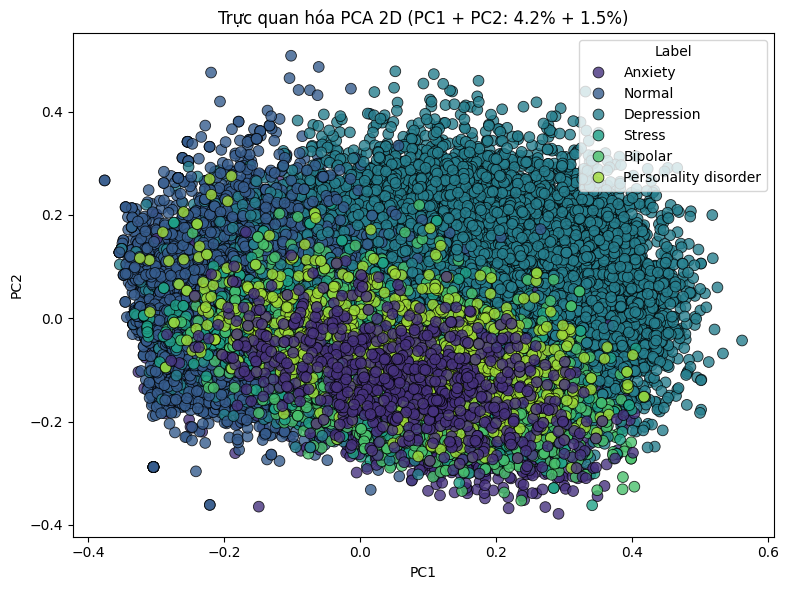

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='status', palette='viridis', s=60, edgecolor='black', alpha=0.8)
plt.title(f'Trực quan hóa PCA 2D (PC1 + PC2: {explained_variance[0]*100:.1f}% + {explained_variance[1]*100:.1f}%)')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

Quan sát dữ liệu khi chiếu xuống 3 thành phần chính có độ lý giải phương sai cao nhất

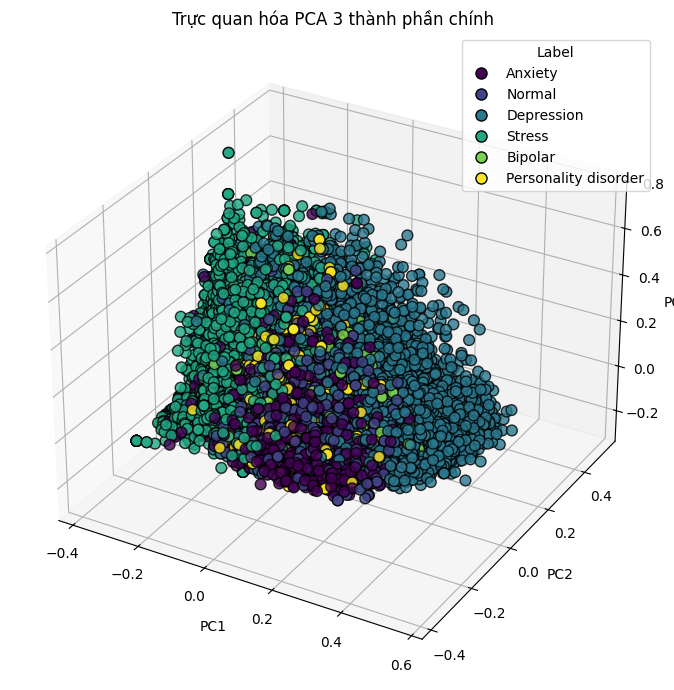

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
    c=df['status_encoded'], cmap='viridis', s=60, alpha=0.8, edgecolors='black'
)

ax.set_title('Trực quan hóa PCA 3 thành phần chính')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

classes = df['status'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[i], markeredgecolor='black', markersize=8,
           label=cls)
    for i, cls in enumerate(classes)
]
ax.legend(handles=legend_elements, title='Label', loc='best')

plt.tight_layout()
plt.show()

Hiển thị trực quan đối với dữ liệu theo từng cặp thành phần chính, áp dụng cho 4 thành phần chính.

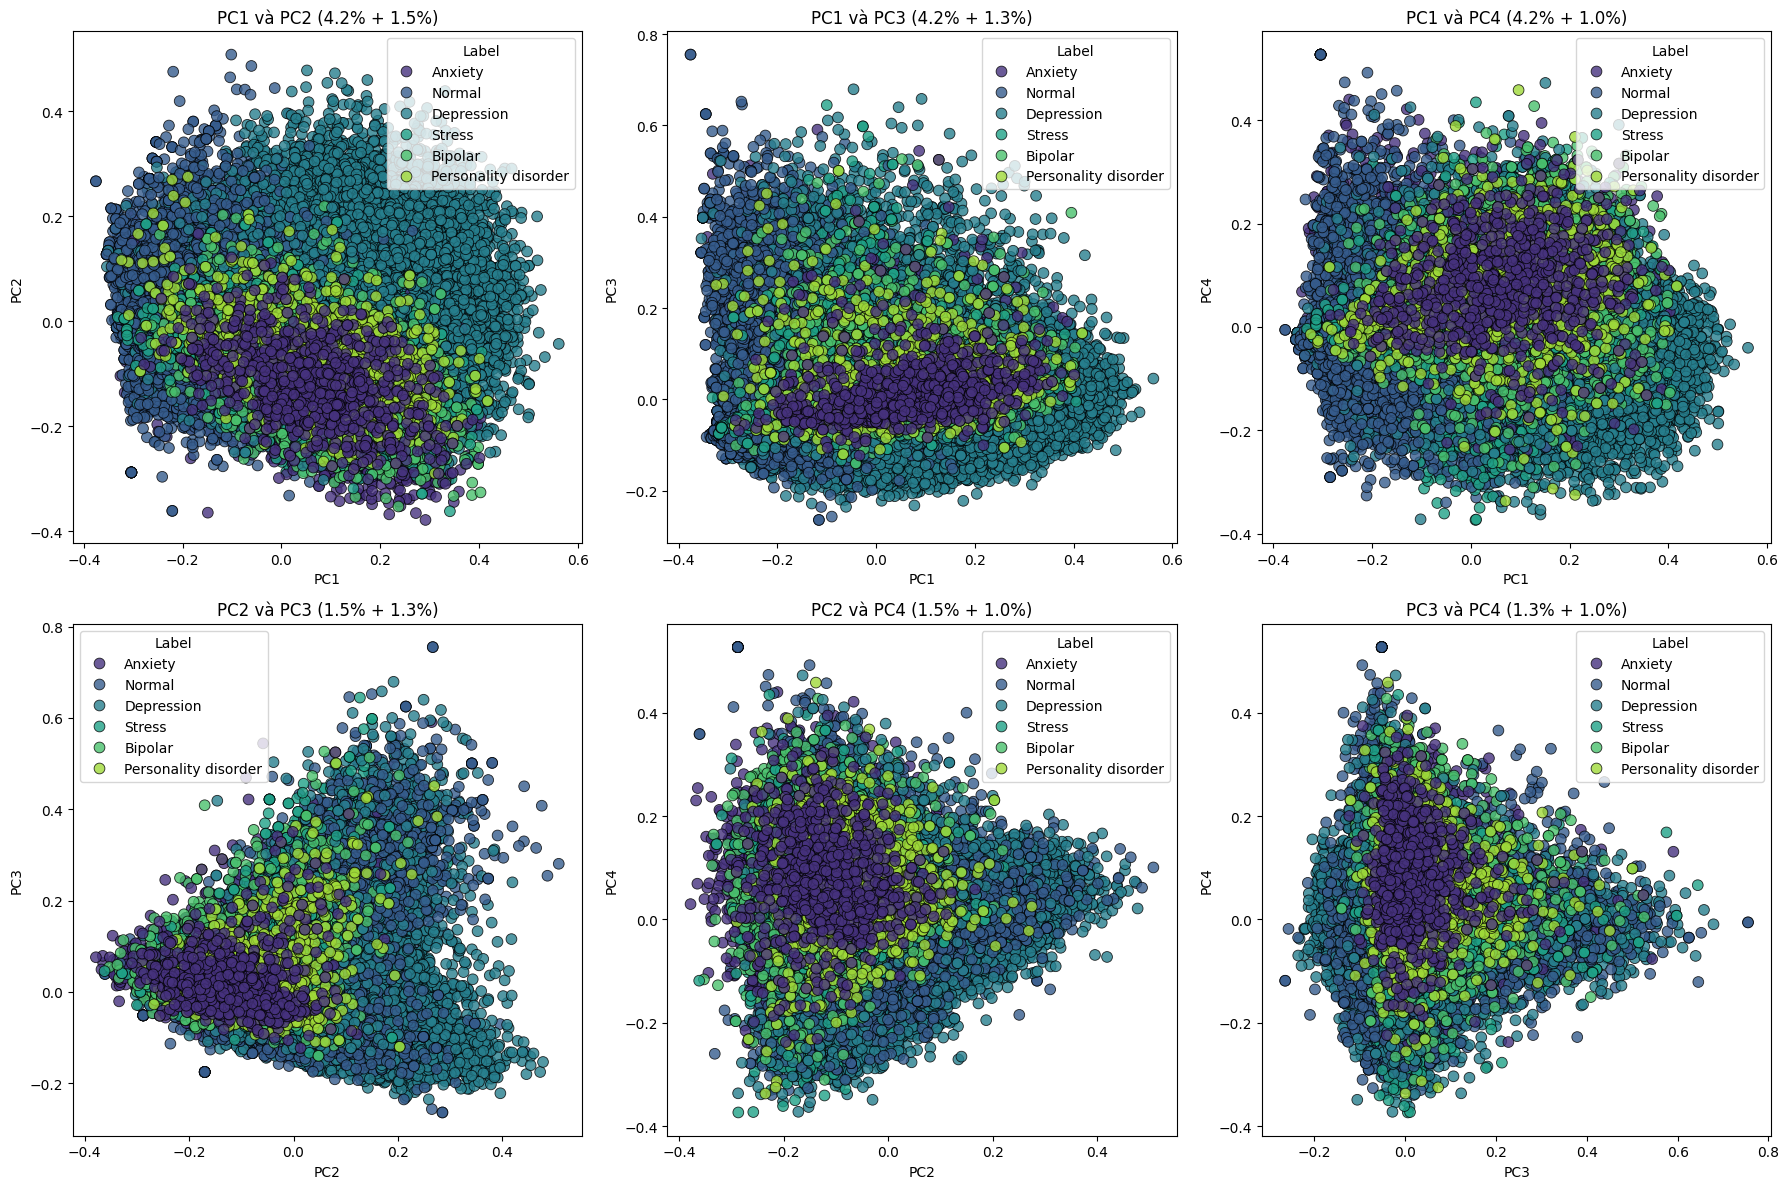

In [ ]:
pair_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'),
                     ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

plt.figure(figsize=(18, 12))
for i, (x, y) in enumerate(pair_combinations):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(
        data=pca_df, x=x, y=y, hue=df['status'],
        palette='viridis', s=60, edgecolor='black', alpha=0.8
    )
    plt.title(
        f'{x} và {y} ({explained_variance[int(x[-1]) - 1] * 100:.1f}% + {explained_variance[int(y[-1]) - 1] * 100:.1f}%)')
    plt.xlabel(x)
    plt.ylabel(y)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Label', loc='best')

plt.tight_layout()
plt.show()

Xác định lượng thông tin được bảo tồn theo phương sai giải thích

In [ ]:
for i, ratio in enumerate(explained_variance, start=1):
    print(f"Thành phần PC{i}: tỷ lệ phương sai giải thích ({ratio * 100} %)")

total_info_retained = explained_variance.sum()
print(f"\nTổng lượng thông tin được giữ lại: {total_info_retained} ({total_info_retained * 100} %)")

Thành phần PC1: tỷ lệ phương sai giải thích (4.214749959738849 %)
Thành phần PC2: tỷ lệ phương sai giải thích (1.5094386721741544 %)
Thành phần PC3: tỷ lệ phương sai giải thích (1.2560795452489817 %)
Thành phần PC4: tỷ lệ phương sai giải thích (0.9814320794207971 %)

Tổng lượng thông tin được giữ lại: 0.07961700256582782 (7.961700256582782 %)


# Trực quan hóa bằng phương pháp LDA

Giảm dữ liệu về 2 chiều bằng phương pháp LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_tfidf.toarray(), df['status_encoded'])

lda_df = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])
lda_df['status'] = df['status']

Quan sát trực quan dữ liệu giảm chiều

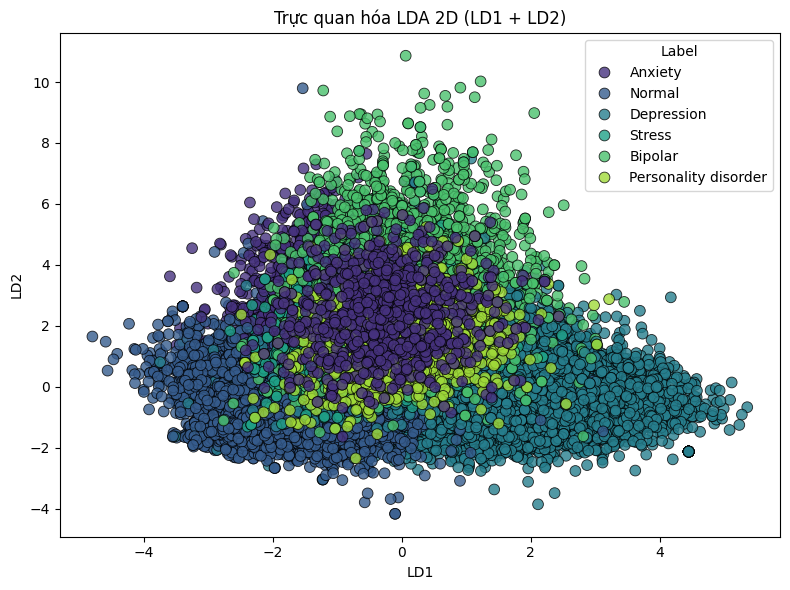

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='status', palette='viridis', s=60, edgecolor='black', alpha=0.8)
plt.title('Trực quan hóa LDA 2D (LD1 + LD2)')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

Giảm dữ liệu về 3 chiều bằng phương pháp LDA

In [ ]:
lda_3d = LinearDiscriminantAnalysis(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_tfidf.toarray(), df['status_encoded'])

lda_df_3d = pd.DataFrame(X_lda_3d, columns=[f'LD{i+1}' for i in range(3)])
lda_df_3d['status'] = df['status']

Quan sát trực quan dữ liệu giảm chiều trong không gian 3 chiều

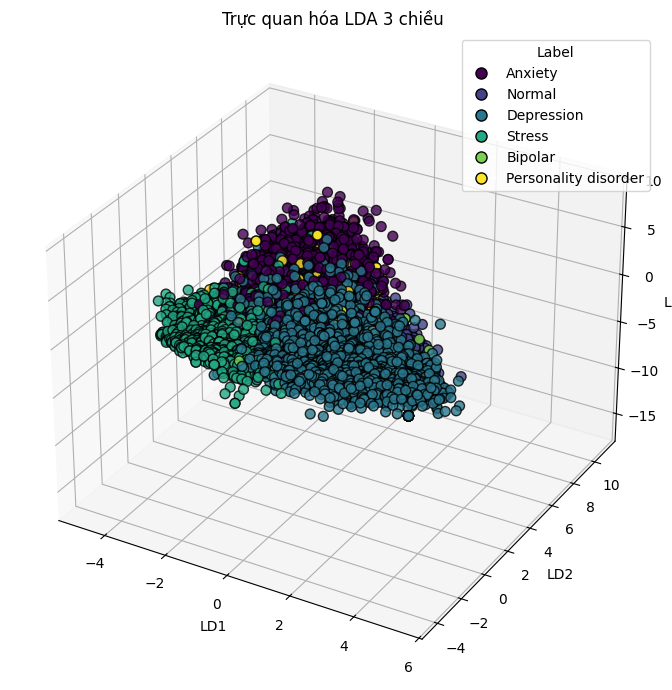

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    lda_df_3d['LD1'], lda_df_3d['LD2'], lda_df_3d['LD3'],
    c=df['status_encoded'], cmap='viridis', s=50, alpha=0.8, edgecolors='black'
)

ax.set_title('Trực quan hóa LDA 3 chiều')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')

from matplotlib.lines import Line2D
import numpy as np

classes = df['status'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=colors[i], markeredgecolor='black', markersize=8,
                          label=cls) for i, cls in enumerate(classes)]
ax.legend(handles=legend_elements, title='Label', loc='best')

plt.tight_layout()
plt.show()

Giảm dữ liệu xuống 4 chiều bằng phương pháp LDA

In [ ]:
lda_4d = LinearDiscriminantAnalysis(n_components=4)
X_lda_4d = lda_4d.fit_transform(X_tfidf.toarray(), df['status_encoded'])

lda_df_4d = pd.DataFrame(X_lda_4d, columns=[f'LD{i+1}' for i in range(4)])
lda_df_4d['status'] = df['status']

Quan sát dữ liệu khi chiếu lên các cặp trục phân biệt tuyến tính

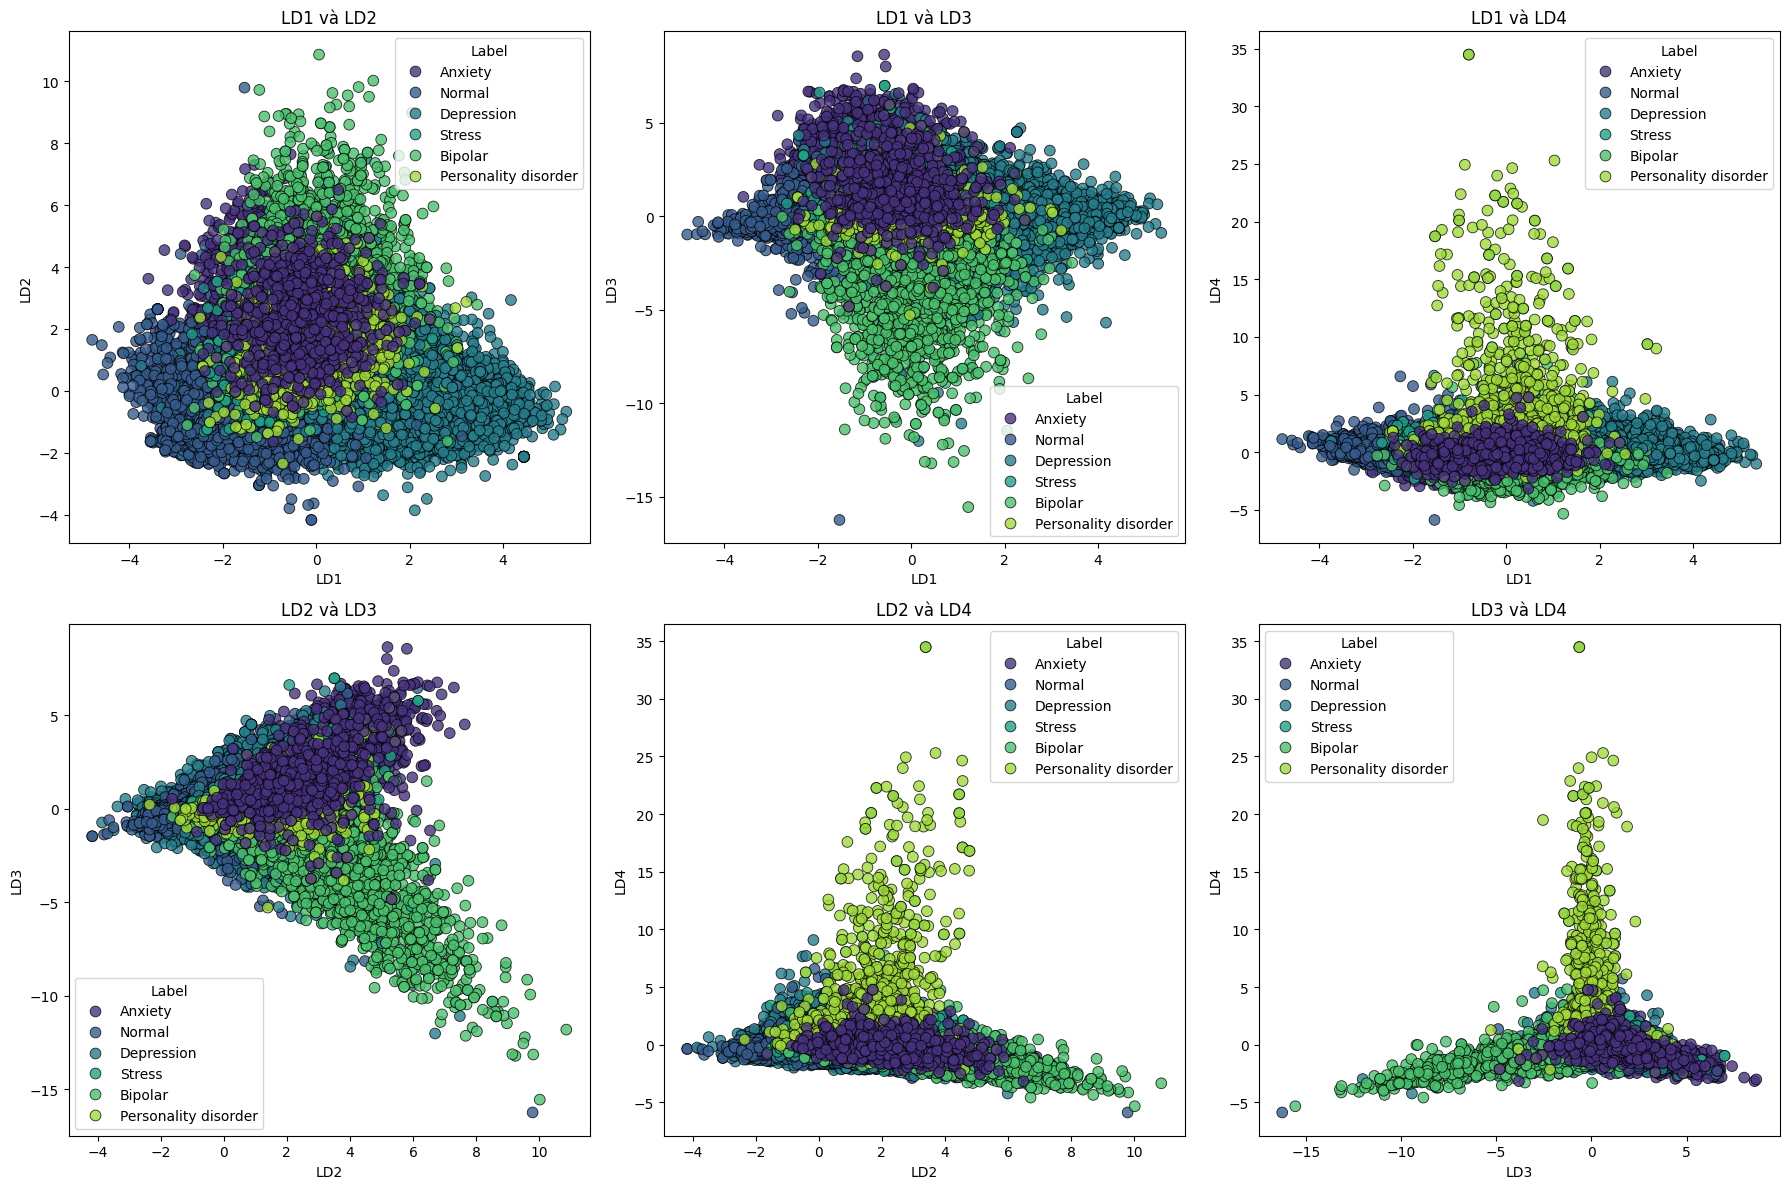

In [ ]:
pair_combinations = [
    ('LD1', 'LD2'),
    ('LD1', 'LD3'),
    ('LD1', 'LD4'),
    ('LD2', 'LD3'),
    ('LD2', 'LD4'),
    ('LD3', 'LD4')
]

plt.figure(figsize=(18, 12))
for i, (x, y) in enumerate(pair_combinations):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(
        data=lda_df_4d, x=x, y=y, hue='status',
        palette='viridis', s=60, edgecolor='black', alpha=0.8
    )
    plt.title(f'{x} và {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='Label', loc='best')

plt.tight_layout()
plt.show()